In [1]:
## 20170412 adapted for 2016 & 2017 CCAR scenarios ## 

import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
test = '_cboUE' 
cbo = ['UE', 'UE, UE_4', 'UE, UE_4, sUE2'] # combo tags (for use in charts)
vrs = [['UE'], ['UE','UE_4'], ['UE','UE_4','sUE2']]
frsq = [0,0,0] # set up list of full model adj r-sq values

grp = 'FailRt'  ## group to analyze within data file

In [144]:
##################################################################################
topn = 3 ## IMPORTANT:  topn defines how many among 3-var models are kept in final tables (pick 3 up to 8)
topx = 2 ## denotes max # of 2-var pairs are allowed in final rankings...(pick 1, 2, or 3)
##################################################################################

###CAUTION: Must manually cycle thru ccar values: 2014, 2015, 2016, 2017
###         and cbon values: 0, 1, 2 (12 cycles)

# NOTE:  Enter parameters here:  (3 lines)
ccar = 2014  ## ALWAYS START WITH 2014 HERE

cbon=0    ## ALWAYS START WITH cbo=0 HERE
#cbon = 1
#cbon = 2

#qtyp = 1 # use 1q charge-off rates (codes in qclst)
qtyp = 4 # use 4q rolling charge-off rates (codes in rclst)

dtst = pd.to_datetime('2001-03-31')  # data start date for all CCAR years

if ccar <= 2015:
  dtend = pd.to_datetime(str(ccar-1) + '-09-30')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+2) + '-12-31')  # end date for CCAR forecast (13-qtr end date)
else:
  dtend = pd.to_datetime(str(ccar-1) + '-12-31')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+3) + '-03-31')  # end date for CCAR forecast (13-qtr end date)


In [145]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables
df = pd.read_csv("FailRates_all2.csv")
adj = pd.read_csv("UE_adj.csv",index_col=0)

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])
df['Date'] = pd.to_datetime(df['Date'])
adj['Date'] = pd.to_datetime(adj['Date'])

## adjust DJ so coeffs are similar scale:
hs['DJ'] = hs['DJ'] / 1000
cc['DJ'] = cc['DJ'] / 1000

## history vars: lag (4q) vars for UE, HPI, CRE:
hs['UE_4'] = hs['UE'].shift(4)  ## add 4q lag version of UE
#hs['HPI_4'] = hs['HPI'].shift(4)
#hs['CRE_4'] = hs['CRE'].shift(4)

## history vars: squared terms for UE and UE_4:
hs['UE2'] = hs['UE'] * hs['UE']

In [146]:
# list of standard loan categories to analyze:
rclst = ['FailRt4q'] 
qclst = ['FailRt']

if qtyp == 1:
  curlst = qclst
elif qtyp == 4:
  curlst = rclst
else:
  curlst = []  # force error if qtyp not 1 or 4

dfc = df.copy()
dfc.dropna(axis=0, how='any', inplace=True)

uvr = "adj" + str(ccar-2000)  ## colname for UE adj factors

## set-up files to analyze CCAR test for a specific year (stored in "ccar" variable):  
ccx = cc[(cc['CCAR'] == ccar)]  # ccx contains forecast periods
ccx = ccx.dropna(axis=1, how='all').reset_index(drop=True)

## CCAR vars: create lag (4q) terms for UE, HPI, CRE:
ccx['UE_4'] = ccx['UE'].shift(4)
if ccar <= 2015:
  ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['UE_4']] = hs.ix[hs.Date==str(ccar-2)+'-09-30',['UE']].values
  ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['UE_4']] = hs.ix[hs.Date==str(ccar-2)+'-12-31',['UE']].values
  ccx.ix[ccx.Date==str(ccar)+'-03-31',['UE_4']] = hs.ix[hs.Date==str(ccar-1)+'-03-31',['UE']].values
  ccx.ix[ccx.Date==str(ccar)+'-06-30',['UE_4']] = hs.ix[hs.Date==str(ccar-1)+'-06-30',['UE']].values
else:
  ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['UE_4']] = hs.ix[hs.Date==str(ccar-2)+'-12-31',['UE']].values
  ccx.ix[ccx.Date==str(ccar)+'-03-31',['UE_4']] = hs.ix[hs.Date==str(ccar-1)+'-03-31',['UE']].values
  ccx.ix[ccx.Date==str(ccar)+'-06-30',['UE_4']] = hs.ix[hs.Date==str(ccar-1)+'-06-30',['UE']].values
  ccx.ix[ccx.Date==str(ccar)+'-09-30',['UE_4']] = hs.ix[hs.Date==str(ccar-1)+'-09-30',['UE']].values
    
## CCAR vars: squared terms for UE and UE_4:
ccx['UE2'] = ccx['UE'] * ccx['UE']
   
ccx.sort_index(by=['Date','Scen'],inplace=True)
ccx = ccx.merge(adj[['Date',uvr]],how='left',on='Date')
ccx.sort_index(by=['Scen','Date'],inplace=True)
ccx[uvr].fillna(1, inplace=True)
ccx['sUE2'] = ccx['UE2'] * ccx[uvr] * ccx[uvr]
ccx.sort_index(by=['Scen','Date'],inplace=True)
ccx.drop(uvr, axis=1, inplace=True)

cccol = list(ccx.columns[3:])  # list of all CCAR variables to analyze

suff = cbo[cbon]
cccol = [k for k in cccol if k in vrs[cbon]] 

Xcol = ['Intercept'] + cccol  # model variables using intercept & all CCAR variables

## sUE2 variable = UE2*adj*adj:
hsf = hs.copy()
hsf = hsf.merge(adj[['Date',uvr]],how='left',on='Date')
hsf[uvr].fillna(1, inplace=True)
hsf['sUE2'] = hsf['UE2'] * hsf[uvr] * hsf[uvr]
hsf.drop(uvr, axis=1, inplace=True)
hsf = hsf.merge(dfc,how='inner',left_on='Date',right_on='Date') # merge fail rates into history file (hs)
hsx = hsf[(hsf['Date'] >= dtst) & (hsf['Date'] <= dtend)] # historic periods
hsx.sort_index(by='Date',inplace=True)
    
ccs = ccx.copy()  # CCAR scenarios for selected year
ccs['Intercept'] = 1  # to set up fitting model

hsf['Intercept'] = 1   # to set up fitting for all available history
hsz = hsf[(hsf['Date'] >= dtst)] # historic periods until current date


In [147]:
# start full model loop here:
for rc in curlst:
  eqn = rc + " ~ " + " + ".join(cccol)
  yt, Xt = dmatrices(eqn , data=hsx, return_type='dataframe')
#  yt, Xt = dmatrices(eqn , data=hsxs, return_type='dataframe')  ## do not use (testing only)
  mod = sm.OLS(yt, Xt)
  res_tot = mod.fit()
  pred_tot = res_tot.predict(Xt)
  p_tot = res_tot.predict(ccs[Xcol])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_tot.predict(hsz[Xcol])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()
  frt2.columns = [[rc]*len(frt.columns),frt.columns]

  prm = res_tot.params
  prm['rsq'] = res_tot.rsquared
  prm['rsq_adj'] = res_tot.rsquared_adj
  prm2 = pd.DataFrame(prm)
  prm2.columns = [rc]

  if rc == curlst[0]:
    frt3 = frt2.copy()
    prm3 = prm2.copy()
  else:
    frt3 = frt3.merge(frt2, how='outer', left_index=True, right_index=True)
    prm3 = prm3.merge(prm2, how='outer', left_index=True, right_index=True)

frsq[cbon] = str(round(prm['rsq_adj']*100,1))

In [148]:
frt3.to_csv(grp +"_"+ str(ccar) + "_full_fcst_" + str(qtyp) + "q_" + suff + test + ".csv")
prm3.to_csv(grp +"_"+ str(ccar) + "_full_param_" + str(qtyp) + "q_" + suff + test + ".csv")
ccar

2017

In [149]:
frsq

['85.2', '85.9', '96.5']

In [150]:
## prints out full regression summary for "no transforms" vtyp == 0 only.
#import sys

sys.stdout = open(str(ccar)+"_"+str(qtyp)+"q_"+suff+"_fullsumm"+ test +".txt", "w")
rsumm = res_tot.summary()
print(rsumm)
sys.stdout = sys.__stdout__

In [151]:
if cbon == 0:
  frt3v0 = frt3.copy()  
elif cbon == 1:
  frt3v1 = frt3.copy()  
elif cbon == 2:
  frt3v2 = frt3.copy()  


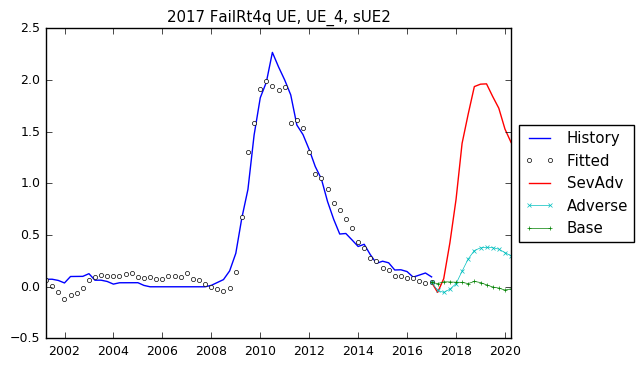

In [152]:
plt.rcParams.update({'font.size': 9})
xax = list(frt3.index)

styp = suff
#for i in np.arange(3):
for i in [0]:
#  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3[curlst[i],'Actual'],ls='-',c='b',lw=1,label='History')
  plt.plot(xax,frt3[curlst[i],'Fit'],ls='None', marker='o',c='w',ms=3,label='Fitted')
  plt.plot(xax,frt3[curlst[i],'SevAdv'],ls='-',c='r',lw=1,label='SevAdv')
  plt.plot(xax,frt3[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=3,c='c',label='Adverse')
  plt.plot(xax,frt3[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',ms=3,label='Base')
  plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
  plt.title(str(ccar)+" "+curlst[i]+" "+styp)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_full1_'+styp+test+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [153]:
cbon

2

In [154]:
###  STOP HERE... run 3 cbon values (cbon=0,1,2)... then proceed

In [155]:
## rename top level of columns from 3 runs for "full" models:
frt3v0.columns = pd.MultiIndex.from_product([[str(ccar)+"_"+cbo[0]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
frt3v1.columns = pd.MultiIndex.from_product([[str(ccar)+"_"+cbo[1]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
frt3v2.columns = pd.MultiIndex.from_product([[str(ccar)+"_"+cbo[2]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
frt3v2.head()

2017_UE, UE_4, sUE2                              
                        Actual       Fit Base Adverse SevAdv
Date                                                        
2001-03-31            0.072372  0.067583  NaN     NaN    NaN
2001-06-30            0.073033  0.009784  NaN     NaN    NaN
2001-09-30            0.061278 -0.050739  NaN     NaN    NaN
2001-12-31            0.037030 -0.116774  NaN     NaN    NaN
2002-03-31            0.099447 -0.082883  NaN     NaN    NaN

In [156]:
## merge the 3 "full" tables into one 
dfp = frt3v0.merge(frt3v1, how='left', left_index=True, right_index=True)
dfp = dfp.merge(frt3v2, how='left', left_index=True, right_index=True)

In [157]:
dfp.head()

2017_UE                               2017_UE, UE_4            \
              Actual       Fit Base Adverse SevAdv        Actual       Fit   
Date                                                                         
2001-03-31  0.072372 -0.294421  NaN     NaN    NaN      0.072372 -0.324722   
2001-06-30  0.073033 -0.224920  NaN     NaN    NaN      0.073033 -0.269172   
2001-09-30  0.061278 -0.085918  NaN     NaN    NaN      0.061278 -0.142022   
2001-12-31  0.037030  0.157335  NaN     NaN    NaN      0.037030  0.065778   
2002-03-31  0.099447  0.226835  NaN     NaN    NaN      0.099447  0.142730   

                               2017_UE, UE_4, sUE2                         \
           Base Adverse SevAdv              Actual       Fit Base Adverse   
Date                                                                        
2001-03-31  NaN     NaN    NaN            0.072372  0.067583  NaN     NaN   
2001-06-30  NaN     NaN    NaN            0.073033  0.009784  NaN     NaN   
2001-09-30  NaN     NaN    NaN            0.061278 -0.050739  NaN     NaN   
2001-12-31  NaN     NaN    NaN            0.037030 -0.116774  NaN     NaN   
2002-03-31  NaN     NaN    NaN            0.099447 -0.082883  NaN     NaN   

                   
           SevAdv  
Date               
2001-03-31    NaN  
2001-06-30    NaN  
2001-09-30    NaN  
2001-12-31    NaN  
2002-03-31    NaN

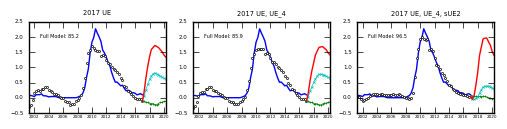

In [158]:
curlst2 = cbo
#dfplst = ['All Vars: ' + e for e in cbo]
dfplst = ['Full Model: ' + e for e in frsq] 

plt.rcParams.update({'font.size': 4})

for i in np.arange(3):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,dfp[str(ccar)+"_"+curlst2[i],'Actual'],ls='-',c='b',lw=1)
  plt.plot(xax,dfp[str(ccar)+"_"+curlst2[i],'Fit'],ls='None', marker='o',c='w',ms=1.5)
  plt.plot(xax,dfp[str(ccar)+"_"+curlst2[i],'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.5)
  plt.plot(xax,dfp[str(ccar)+"_"+curlst2[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.5,c='c')
  plt.plot(xax,dfp[str(ccar)+"_"+curlst2[i],'SevAdv'],ls='-',c='r',lw=1)
  plt.annotate(dfplst[i], xy=(0.08, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation

  plt.title(str(ccar)+" "+curlst2[i])

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom='on') # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_full'+ test +'.png', dpi=400, bbox_inches='tight')
plt.show()

In [159]:
# dfp, frsq

#if ccar == 2013:
#  dfp13 = dfp.copy()
#  frsq13 = frsq.copy()
if ccar == 2014:
  dfp14 = dfp.copy()
  frsq14 = frsq.copy()
if ccar == 2015:
  dfp15 = dfp.copy()
  frsq15 = frsq.copy()
if ccar == 2016:
  dfp16 = dfp.copy()
  frsq16 = frsq.copy()
if ccar == 2017:
  dfp17 = dfp.copy()
  frsq17 = frsq.copy()

In [160]:
ccar

2017

In [151]:
#STOP until 2017 is completed

In [152]:
## stop until all years are run

In [161]:
#frsq13a = ['2013: ' + e for e in frsq13]
frsq14a = ['2014: ' + e for e in frsq14]
frsq15a = ['2015: ' + e for e in frsq15]
frsq16a = ['2016: ' + e for e in frsq16]
frsq17a = ['2013: ' + e for e in frsq17]

frsqa = frsq14a + frsq15a + frsq16a + frsq17a
frsqa

['2014: 85.8',
 '2014: 86.7',
 '2014: 96.0',
 '2015: 85.5',
 '2015: 85.9',
 '2015: 96.6',
 '2016: 85.5',
 '2016: 86.1',
 '2016: 96.5',
 '2013: 85.2',
 '2013: 85.9',
 '2013: 96.5']

In [162]:
dfpa = dfp14.copy()
dfpa = dfpa.merge(dfp15, how='outer', left_index=True, right_index=True)
dfpa = dfpa.merge(dfp16, how='outer', left_index=True, right_index=True)
dfpa = dfpa.merge(dfp17, how='outer', left_index=True, right_index=True)


In [163]:
#cbot = ['UE only','UE, UE_4','UE, UE_4, UE2, UE_42']
dfpa0 = list(dfpa.columns.levels[0])
dfpa0

['2014_UE',
 '2014_UE, UE_4',
 '2014_UE, UE_4, sUE2',
 '2015_UE',
 '2015_UE, UE_4',
 '2015_UE, UE_4, sUE2',
 '2016_UE',
 '2016_UE, UE_4',
 '2016_UE, UE_4, sUE2',
 '2017_UE',
 '2017_UE, UE_4',
 '2017_UE, UE_4, sUE2']

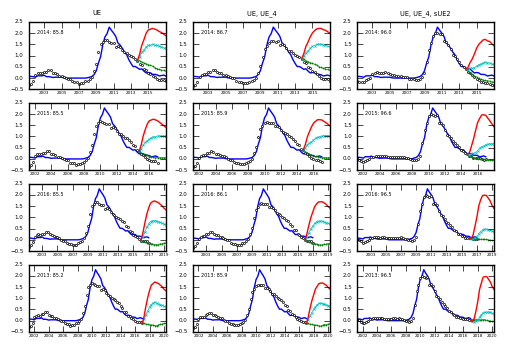

In [166]:
xax = list(dfp.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(12):
  plt.subplot(4, 3, i+1)
  plt.plot(xax,dfpa[dfpa0[i],'Actual'],ls='-',c='b',lw=1)
  plt.plot(xax,dfpa[dfpa0[i],'Fit'],ls='None', marker='o',c='w',ms=1.5)
  plt.plot(xax,dfpa[dfpa0[i],'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.5)
  plt.plot(xax,dfpa[dfpa0[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.5,c='c')
  plt.plot(xax,dfpa[dfpa0[i],'SevAdv'],ls='-',c='r',lw=1)
  plt.annotate(frsqa[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation

  if i < 3: plt.title(cbo[i])

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom='on') # labels along the bottom edge are off

plt.savefig(grp+'_'+"allyr_" + str(qtyp) + "q"+ test +'_2014_2017.png', dpi=400, bbox_inches='tight')
plt.show()

In [167]:
grp+'_'+"allyr_" + str(qtyp) + "q"+ test +'_2014_2017.png'

'FailRt_allyr_4q_cboUE_2014_2017.png'